<a href="https://colab.research.google.com/github/anirbrhm/model-zoo-submissions/blob/anirbrhm-patch-1/Resnet34/Resnet34-Implementation-on-CIFAR10-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Utilities 

### Some basic Imports 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import pdb

### Resnet architecture from torchvision
First let us understand what we are trying to replicate. For that we look at the RESNET-34 model from PyTorch. 

In [ ]:
models.resnet34()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Building ResNet 

### Input
Grab random input to understand how feature maps are generated in convolution layer.

Pytorch nn.Conv2d layer expects inputs of (batch_size, channels, height, width).

We are considering batch size of 2, 3 RGB color channels, height and width of 224 each. It is a rank 4 tensor.

In [ ]:
inp = torch.randn([2,3,224,224])

In [ ]:
inp.shape ## bs,rgb channels,width,height

torch.Size([2, 3, 224, 224])

### Convolution block
First we are going to construct a small sequential network for initial convolution block of resnet. It's the very first layer in our resnet architecture.

It consists of 4 operations,

1. Convolution
2. Batch Normalization
3. ReLU activation function
4. Maxpooling

In [ ]:
conv_block = nn.Sequential(nn.Conv2d(3,64,kernel_size=7, stride=2, padding=3, bias=False), #112,112
                       nn.BatchNorm2d(64),
                       nn.ReLU(inplace=True),
                       nn.MaxPool2d(kernel_size=3, stride=2, padding=1)) # 56,56
conv_block

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
)

Conv2d layer takes 3 input channels and generate 64 filters/channels i.e feature maps. We can choose how many features we want to generate by convolution operation.

Here, kernel size is 7 X 7 , stride is 2 and padding 3. Padding adds border of zeros around your input matrix.

Conv2d layer downsamples input when stride is equal to 2, i.e convolution window skips over 1 pixel.

So after conv2d layer output shape will be (2,64,112,112) tensor of activations. Basically height and width of input grid reduces to half.

In [ ]:
# Just an illustration, do not execute this. Dimensions will get messed up 
# inp=nn.Conv2d(3,64,kernel_size=7, stride=2, padding=3, bias=False)(inp)
# inp.shape

After maxpooling operation with stride of 2 again output from conv2d->batchNorm->Relu gets downsampled to half.

Let's check what is shape of output after conv_block operations.

In [ ]:
out = conv_block(inp)
out.shape

torch.Size([2, 64, 56, 56])

In [ ]:
list(models.resnet34().children())[:4]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)]

### Residual Block 
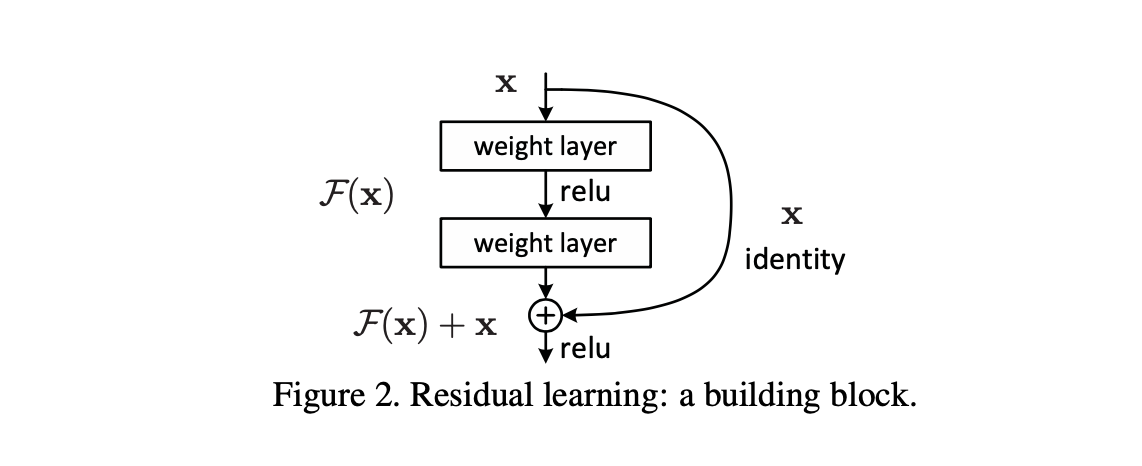

After 2 convolution operations input of those 2 convolution is added to their output.

**Basic Block**

Each basic block constitutes of 2 convolution operations.

Each convolutional layer is followed by a batch normalization layer and a ReLU activation function.

except if downsample has to be applied the 2nd conv layer's output is added to input before applying relu.

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)

        return out

In [ ]:
BasicBlock(64,128)

BasicBlock(
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
t = torch.randn((2,64,56,56))
t.shape

torch.Size([2, 64, 56, 56])

In [ ]:
BasicBlock(64,64)(t).shape

torch.Size([2, 64, 56, 56])

make_layer()
Next 4 layers after initial conv_block are called as layer 1, 2, 3, 4 respectively. Each layer consists of multiple convolution blocks. Conv_block refers to set of operations as in Convolution->BatchNorm->ReLU activation to an input. Instead of adding new layers to create a deeper neural network, resnet authors added many conv_block within each layer, thus keeping depth of neural network same - 4 layers.

In the PyTorch implementation they distinguish between the blocks that includes 2 operations – Basic Block – and the blocks that include 3 operations – Bottleneck Block.

The make_layer() function takes which type of block to use as an argument, the number of input and output filters, and number of blocks to be stacked together. Every layer downsamples the input at the start using stride equals to 2 i.e for 1st convolutional layer in 1st block of a layer. For all the rest convolution layers stride is 1. Also, if downsample has to be applied to input stride 2 convolution is used followed by BatchNorm.

In [ ]:
def _make_layer(block, inplanes,planes, blocks, stride=1):
    downsample = None  
    if stride != 1 or inplanes != planes:
        downsample = nn.Sequential(            
            nn.Conv2d(inplanes, planes, 1, stride, bias=False),
            nn.BatchNorm2d(planes),
        )
    layers = []
    layers.append(block(inplanes, planes, stride, downsample))
    inplanes = planes
    for _ in range(1, blocks):
        layers.append(block(inplanes, planes))
    return nn.Sequential(*layers)

In [ ]:
layers=[3, 4, 6, 3]

In [ ]:
layer1 =_make_layer(BasicBlock, inplanes=64,planes=64, blocks=layers[0])
layer1

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, mome

In [ ]:
list(models.resnet34().children())[4]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, mome

In [ ]:
layer2 = _make_layer(BasicBlock, 64, 128, layers[1], stride=2)
layer2

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-

In [ ]:
list(models.resnet34().children())[5]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-

why we need to downsample input

In [ ]:
t = torch.rand((2,64,56,56))
t.shape #batch, RGB channels/filters,width,height

torch.Size([2, 64, 56, 56])

In [ ]:
o = nn.Conv2d(64,128,3,2,1)(t)
o.shape

torch.Size([2, 128, 28, 28])

In [ ]:
torch.Size([2, 128, 28, 28])

torch.Size([2, 128, 28, 28])

In [ ]:
t_d =nn.Conv2d(64,128,1,2,0)(t)
o.shape,t_d.shape

(torch.Size([2, 128, 28, 28]), torch.Size([2, 128, 28, 28]))

In [ ]:
(o+t_d).shape

torch.Size([2, 128, 28, 28])

Classifier block
This is a fully connected layer. It's the final layer in our resnet architecture. It consists of 3 operations -

Average pooling layer - aggregates all features. It's output grid size is 1X 1 which forms rank 3 tensor of (512, 1,1)

Flatten- Our loss function expects a vector of tensor instead of rank 3 tensor. So in forward() we call 'torch.flatten' to remove any unit axis from matrix and make it just a vector of length 512.

x = torch.flatten(x, 1)

Linear Layer - It's a fully connected layer just before applying softmax, which takes in 512 features and outputs 1000 class probabilities. (In case of Imagenet, we have 1000 categories.)

In [ ]:
num_classes=1000
nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
              nn.Linear(512 , num_classes))

Sequential(
  (0): AdaptiveAvgPool2d(output_size=(1, 1))
  (1): Linear(in_features=512, out_features=1000, bias=True)
)

Let's confirm our classifier block matches Pytorch's resnet implementation

In [ ]:
list(models.resnet34().children())[8:]

[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000, bias=True)]

### Resnet class

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        super().__init__()
        
        self.inplanes = 64

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 , num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None  
   
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        
        self.inplanes = planes
        
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)           # 224x224
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)         # 112x112

        x = self.layer1(x)          # 56x56
        x = self.layer2(x)          # 28x28
        x = self.layer3(x)          # 14x14
        x = self.layer4(x)          # 7x7

        x = self.avgpool(x)         # 1x1
        x = torch.flatten(x, 1)     # remove 1 X 1 grid and make vector of tensor shape 
        x = self.fc(x)

        return x

### Creating Resnet34 model

In [ ]:
def resnet34():
    layers=[3, 4, 6, 3]
    model = ResNet(BasicBlock, layers)
    return model

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
model = resnet34().to(device)

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Training and Testing 

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [ ]:
# Hyper-parameters
num_epochs = 80
learning_rate = 0.001

In [ ]:
# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

In [ ]:
# Hyper-parameters
num_epochs = 80
learning_rate = 0.001

In [ ]:
# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

In [ ]:
# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())


Extracting ../../data/cifar-10-python.tar.gz to ../../data/


In [ ]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          shuffle=False)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch [1/80], Step [100/500] Loss: 1.7778
Epoch [1/80], Step [200/500] Loss: 1.5907
Epoch [1/80], Step [300/500] Loss: 1.4552
Epoch [1/80], Step [400/500] Loss: 1.4281
Epoch [1/80], Step [500/500] Loss: 1.1356
Epoch [2/80], Step [100/500] Loss: 1.2551
Epoch [2/80], Step [200/500] Loss: 1.4720
Epoch [2/80], Step [300/500] Loss: 1.2662
Epoch [2/80], Step [400/500] Loss: 0.9641
Epoch [2/80], Step [500/500] Loss: 1.0169
Epoch [3/80], Step [100/500] Loss: 1.2081
Epoch [3/80], Step [200/500] Loss: 0.9845
Epoch [3/80], Step [300/500] Loss: 1.0354
Epoch [3/80], Step [400/500] Loss: 0.8931
Epoch [3/80], Step [500/500] Loss: 1.0235
Epoch [4/80], Step [100/500] Loss: 1.1874
Epoch [4/80], Step [200/500] Loss: 1.0035
Epoch [4/80], Step [300/500] Loss: 0.9879
Epoch [4/80], Step [400/500] Loss: 1.0200
Epoch [4/80], Step [500/500] Loss: 0.8355
Epoch [5/80], Step [100/500] Loss: 0.6397
Epoch [5/80], Step [200/500] Loss: 0.8216
Epoch [5/80], Step [300/500] Loss: 0.8740
Epoch [5/80], Step [400/500] Loss:

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 86.12 %


In [ ]:
# Save the model checkpoint
torch.save(model.state_dict(),'resnet.ckpt')